# Prepping

Mount tới drive của mình

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Tạo shortcut cho thư mục của tên mình

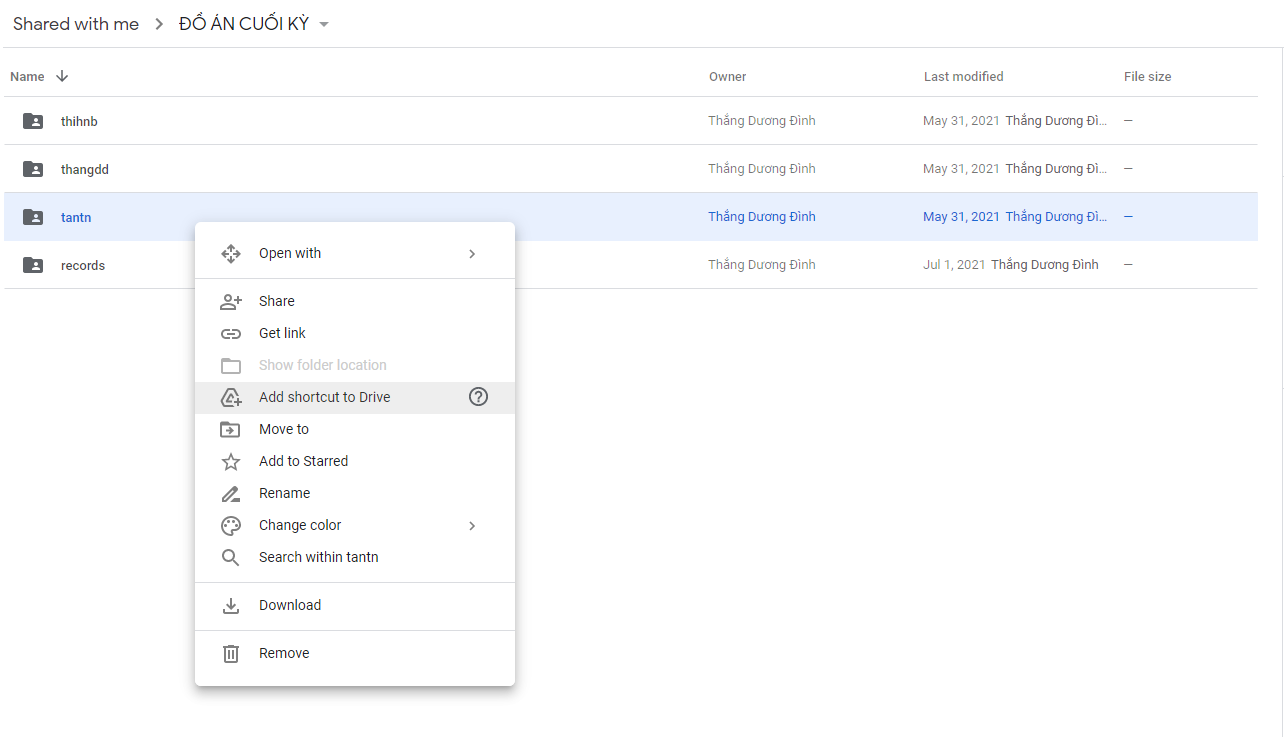

`!cd` tới thư mục vừa tạo shortcut. Thay `tantn` thành thư mục của tên mình.

In [ ]:
%cd /content/drive/MyDrive/tantn/
# %cd /content/drive/MyDrive/tantn/CS106-Vietnam-Stock-Trading
# %cd /content/drive/MyDrive/tantn/CS106-Vietnam-Stock-Trading/finrl

/content/drive/.shortcut-targets-by-id/1IIWkD8hCQPsUQr23fpYjodqsLwetr7om/tantn


In [ ]:
%mkdir CS106-Vietnam-Stock-Trading

In [ ]:
%cd CS106-Vietnam-Stock-Trading

[Errno 2] No such file or directory: 'CS106-Vietnam-Stock-Trading'
/content


In [ ]:
%cd /content/drive/MyDrive/CS106-Vietnam-Stock-Trading-Result/

/content/drive/MyDrive/CS106-Vietnam-Stock-Trading-Result


In [ ]:
!sudo apt-get update && sudo apt-get install cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx

In [ ]:
!pip install git+https://github.com/ThangDuong59/CS106-Vietnam-Stock-Trading.git

**Kết quả sẽ được lưu tại:** /content/drive/MyDrive/tantn/CS106-Vietnam-Stock-Trading/results

## Essential modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime
import itertools

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.marketdata.vnquantdownloader import vnquantDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.model.models import DRLAgent, DRLEnsembleAgent
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [ ]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

# Data

In [ ]:
config.SINGLE_TICKER = ['VNM']
config.SINGLE_TICKER

['VNM']

In [ ]:
df = vnquantDownloader(start_date=config.START_DATE,
                        end_date=config.END_DATE,
                        ticker_list=config.SINGLE_TICKER, ).fetch_data()

2021-07-18 07:39:29,293 : INFO : NumExpr defaulting to 2 threads.
2021-07-18 07:39:29,300 : INFO : data VNM from 2013-01-02 to 2021-07-01 have already cloned!


Shape of DataFrame:  (2117, 8)


In [ ]:
df.tail(20)

## Download data

In [ ]:
now = datetime.datetime.now().strftime("%Y%m%d-%Hh%M")
# df.to_csv("./" + config.DATA_SAVE_DIR + "/" + now + ".csv")

## Data adjustment

In [ ]:
fe = FeatureEngineer(use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)

In [ ]:
processed = fe.preprocess_data(df)

list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(
    processed['date'].min(), processed['date'].max()).astype(str))
combination = list(itertools.product(list_date, list_ticker))

processed_full = pd.DataFrame(combination, columns=["date", "tic"]).merge(
    processed, on=["date", "tic"], how="left")
processed_full = processed_full[processed_full['date'].isin(
    processed['date'])]
processed_full = processed_full.sort_values(['date', 'tic'])

processed_full = processed_full.fillna(0)

Successfully added technical indicators
Successfully added turbulence index


In [ ]:
processed_full.sample(n = 20)

In [ ]:
train = data_split(processed_full, config.START_DATE,
                    config.START_TRADE_DATE)
trade = data_split(
    processed_full, config.START_TRADE_DATE, config.END_DATE)

In [ ]:
stock_dimension = len(train.tic.unique())
state_space = (
    1
    + 2 * stock_dimension
    + len(config.TECHNICAL_INDICATORS_LIST) * stock_dimension
)

In [ ]:
stock_dimension, state_space

(1, 7)

# Implementation

## Env initial params

In [ ]:
env_kwargs = {
        "hmax": 50000,                                                            
        "initial_amount": 100000000,
        "buy_cost_pct": 0.0015,
        "sell_cost_pct": 0.0015,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST,
        "action_space": stock_dimension,
        "reward_scaling": 1e-4
    }

## Env initialization

In [ ]:
e_train_gym = StockTradingEnv(df=train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()

agent = DRLAgent(env=env_train)

## Model training

### SAC model

In [ ]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime("%Y%m%d-%Hh%M")

model_sac = agent.get_model("sac")
trained_sac = agent.train_model(
    model=model_sac, tb_log_name="sac", total_timesteps=100000
)

### A2C model

In [ ]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime("%Y%m%d-%Hh%M")

model_a2c = agent.get_model("a2c")
trained_a2c = agent.train_model(
    model=model_a2c, tb_log_name="a2c", total_timesteps=100000
)

==============Model Training===========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_1
------------------------------------
| time/                 |          |
|    fps                | 182      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.42    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -99.7    |
|    std                | 1        |
|    value_loss         | 8.95e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 241      |
|    iterations         | 200      |
|    time_elapsed       | 4        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -1.43  

### PPO model

In [ ]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime("%Y%m%d-%Hh%M")

model_ppo = agent.get_model("ppo")
trained_ppo = agent.train_model(
    model=model_ppo, tb_log_name="ppo", total_timesteps=100000
)

==============Model Training===========
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Logging to tensorboard_log/ppo/ppo_1
-----------------------------
| time/              |      |
|    fps             | 399  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 391          |
|    iterations           | 2            |
|    time_elapsed         | 10           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0013894257 |
|    clip_fraction        | 0.0102       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -0.000149    |
|    learning_rate        | 0.00025      |
|    loss                 | 1.28e+04     |
|    n_update

### DDPG model

In [ ]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime("%Y%m%d-%Hh%M")

model_ddpg = agent.get_model("ddpg")
trained_ddpg = agent.train_model(
    model=model_ddpg, tb_log_name="ppo", total_timesteps=50000
)

### TD3 model

In [ ]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime("%Y%m%d-%Hh%M")

model_td3 = agent.get_model("td3")
trained_td3 = agent.train_model(
    model=model_td3, tb_log_name="td3", total_timesteps=30000
)

==============Model Training===========
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device
Logging to tensorboard_log/td3/td3_1
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 158      |
|    time_elapsed    | 37       |
|    total timesteps | 5976     |
| train/             |          |
|    actor_loss      | 3.97e+04 |
|    critic_loss     | 2.6e+09  |
|    learning_rate   | 0.001    |
|    n_updates       | 4482     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 143      |
|    time_elapsed    | 83       |
|    total timesteps | 11952    |
| train/             |          |
|    actor_loss      | 2.98e+04 |
|    critic_loss     | 1.99e+07 |
|    learning_rate   | 0.001    |
|    n_updates       | 10458    |
---------------------------------
day: 1493, episode: 1

### Ensemble Agent

In [ ]:
# env_esemble_kwargs
train_period = [config.START_DATE, config.START_TRADE_DATE]
val_test_period = [config.START_TRADE_DATE, config.END_DATE]

env_ensemble_kwargs = {
        "df": processed_full,
        "train_period": train_period,
        "val_test_period": val_test_period,
        "rebalance_window": 63,
        "validation_window": 63,
        "stock_dim": stock_dimension,
        "hmax": 50000,
        "initial_amount": 100000000,
        "buy_cost_pct": 0.0015,
        "sell_cost_pct": 0.0015,
        "reward_scaling": 1e-4,
        "state_space": state_space,
        "action_space": stock_dimension,
        "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST,
        "print_verbosity": 10
    }

timesteps_dict = {
        'a2c': 100000,
        'ppo': 100000,
        'ddpg': 50000
    }

In [ ]:
# Initialize Ensemble Agent
ensembleAgent = DRLEnsembleAgent(**env_ensemble_kwargs)

In [ ]:
# Train 
print("==============Model Training===========")
now = datetime.datetime.now().strftime("%Y%m%d-%Hh%M")
ensemble_model = ensembleAgent.run_ensemble_strategy(
    config.A2C_PARAMS, config.PPO_PARAMS, config.DDPG_PARAMS, timesteps_dict=timesteps_dict)
ensemble_model.to_csv(
    "./" + config.RESULTS_DIR + "/df_ensemble_summary" + now + ".csv")

## Model trading

**Đổi model trading thành model trading vừa mới được train ở phía trên**

In [ ]:
print("==============Start Trading===========")
e_trade_gym = StockTradingEnv(
    df=trade, turbulence_threshold=250, **env_kwargs)

df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ddpg, environment=e_trade_gym                          # Đổi model
)
df_account_value.to_csv(
    "./" + config.RESULTS_DIR + "/df_account_value_" + now + ".csv"
)
df_actions.to_csv("./" + config.RESULTS_DIR +
                    "/df_actions_" + now + ".csv")

==============Start Trading===========
hit end!


## Backtest

In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime("%Y%m%d-%Hh%M")
perf_stats_all = backtest_stats(df_account_value)              # Đổi lại thành df_account_value
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./" + config.RESULTS_DIR +
                        "/perf_stats_all_" + now + ".csv")